In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sb

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

%matplotlib inline

data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition-Copy1.csv")
data.dropna(inplace=True)
data.head(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,1,80,3,12,3,2,1,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,...,2,80,1,1,2,3,1,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,...,2,80,0,10,2,3,9,7,1,8
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,...,2,80,2,17,3,2,7,7,7,7


After uploading my data into 'data', I am in the process of compiling down my data by extracting and manipulating code into a workable dataset. To do this I first need to determine all the different types of values and convert them into integers so that I can input it into sklearn cross validation as well as for the heatmap.

In [2]:
#Here I created new features that convert string based classifiers into integers to denote their values
#so that cross validation and hold outs can work using those values
data['IntBusinessTravel'] = data['BusinessTravel'].apply(lambda x:0 if x == "Non-Travel" else (1 if x == "Travel_Rarely" else 2))
data['IntDepartment'] = data['Department'].apply(lambda x:0 if x == "Research & Development" else (1 if x == "Sales" else 2))
data['IntEducationField'] = data['EducationField'].apply(lambda x:0 if x == "Life Sciences" else (1 if x == "Medical" else (2 if x == "Marketing" else (3 if x == 'Technical Degree' else (4 if x == 'Other' else 5)))))
data['IntGender'] = data['Gender'].apply(lambda x:0 if x == "Female" else 1)
data['Attrition'] = data['Attrition'].apply(lambda x:0 if x == "No" else 1)

Question: Can we predict the Attrition rate based on factors that are uncontrollable by the company? (Such as education, gender, distance from work etc.)

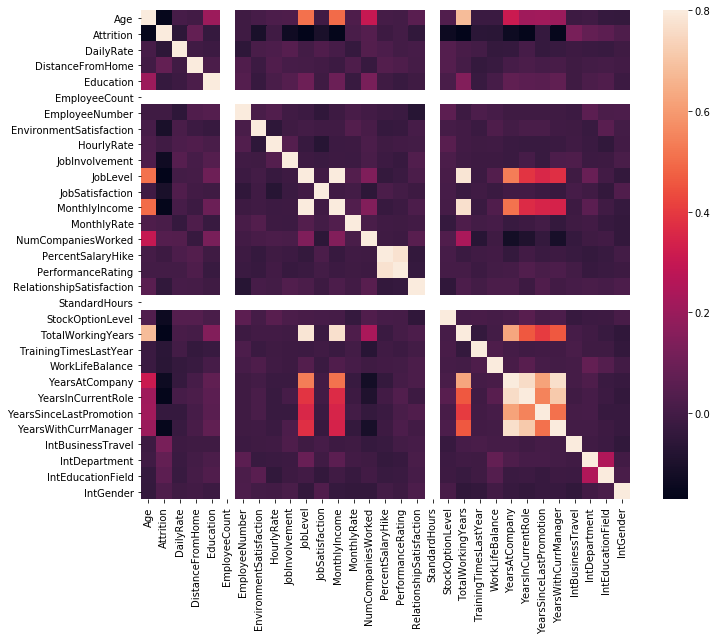

In [3]:
#Here I create the heatmap in order to find correlation between different features, the aim here is to find the 
#variables with the most correlation with IntAttrition as they will most likely help with describing variance
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sb.heatmap(corrmat, vmax=.8,square=True)
plt.show()

By creating a heat map we can use it to tell us how closely some values are correlated to each other. For Attrition it seems that it has some correlation towards certain values, most notably Business Travel and Distance From Home. There does not seem to be much co-relation with Age or Education however.

Text(0.5, 1.0, 'Attrition based on Relationship Satisfaction')

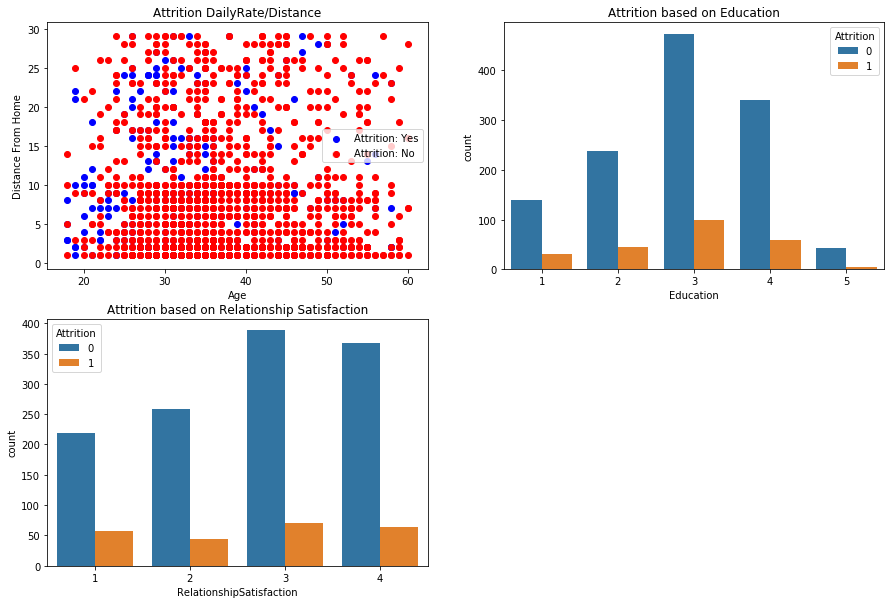

In [4]:
# Look at our data by creating many different types of graphs
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
#Create a KNN plot to see how the data spread is between the age and distance from home based on Attrition
plt.scatter(
    data[data['Attrition'] == 1].Age,
    data[data['Attrition'] == 1].DistanceFromHome,
    color='blue'
)
plt.scatter(
    data[data['Attrition'] == 0].Age,
    data[data['Attrition'] == 0].DistanceFromHome,
    color='red'
)
plt.legend(['Attrition: Yes', 'Attrition: No'])
plt.title('Attrition DailyRate/Distance')
plt.xlabel('Age')
plt.ylabel('Distance From Home')

#Created a countplot to see how Education affects Attrition
plt.subplot(2, 2, 2)
sb.countplot(data=data, x="Education", hue="Attrition")
plt.title('Attrition based on Education')

#Created a countplot to see how Relationship Satisfication affects Attrition
plt.subplot(2, 2, 3)
sb.countplot(data=data, x="RelationshipSatisfaction", hue="Attrition")
plt.title('Attrition based on Relationship Satisfaction')

Looking at the data these graphs aren't too helpful in determining how they affect attrition, but it does give us some indicators as to which stages of each attribute has the most attrition (for example a BA degree in Education has a much higher rate of attrition then the others).

Since our target is Attriton, we are going to test if our data is over sampled or under sampled, in either case we will need to resample it so that the data isn't heavily skewed. So let's check:
# Resample

Class 0: 1233
Class 1: 237
Proportion: 5.2 : 1


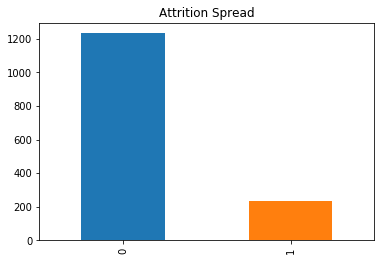

In [5]:
target_count = data.Attrition.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Attrition Spread');

In [6]:
from sklearn.utils import resample
# Separate majority and minority classes
data_majority = data[data.Attrition==0]
data_minority = data[data.Attrition==1]
 
# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1233)    # to match majority class
 
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
data_upsampled.Attrition.value_counts()
#data_upsampled.plot(kind='bar', title='Attrition Spread');

1    1233
0    1233
Name: Attrition, dtype: int64

Now that our data is balanced in terms of Attrition, we can go take a look at how different models compare to one another.
First we shall create our target and feature_selected_data to test our models with

In [7]:
#Here I create a seperate table that only has attrition as 0 for no and 1 for yes for use in cross validation and holdout
target = data_upsampled['Attrition'].copy()
#target = target.apply(lambda x:0 if x == "No" else 1)

#Here I created another table with just the features I want to test out for the incoming question
feature_cols = ['Age','DistanceFromHome','Education','RelationshipSatisfaction','WorkLifeBalance']
feature_selected_data = data_upsampled[feature_cols].copy()

# Regular

--- 0.0 seconds ---


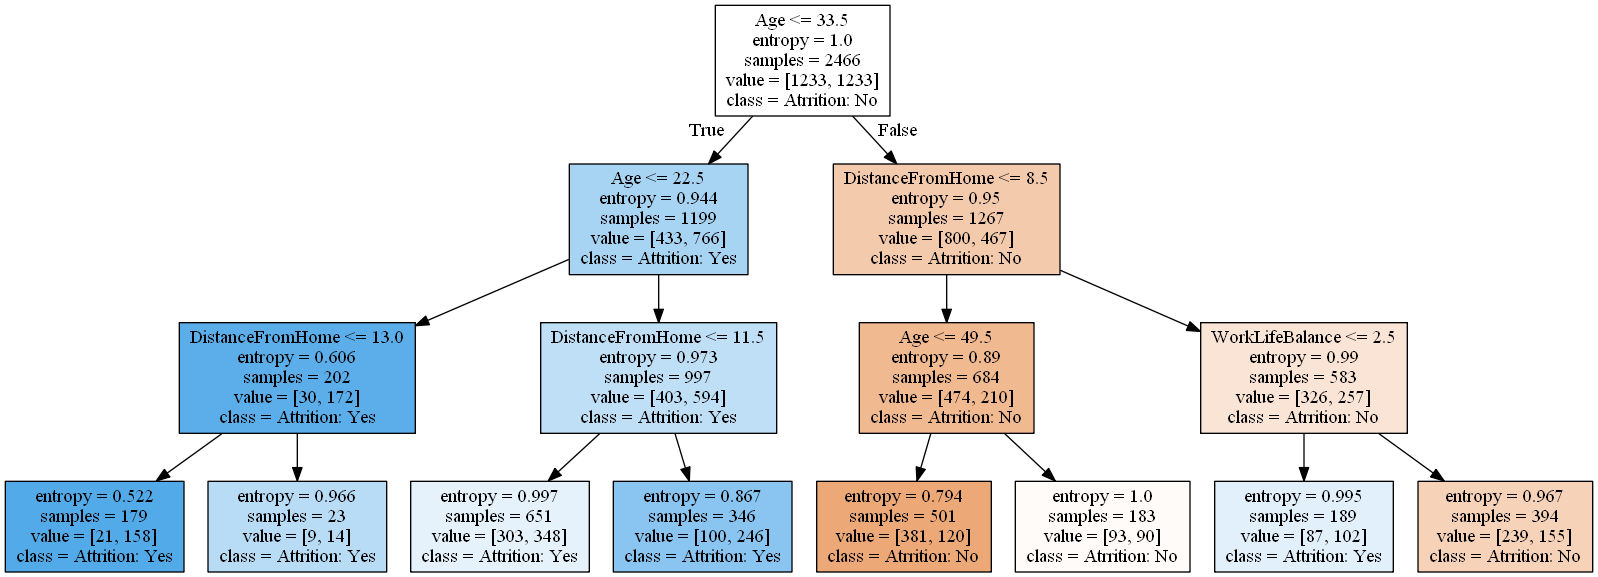

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

#This initiates the DecisionTreeClassifier with the attributes that we want
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 5, #Use the 2 features in PCA
    max_depth = 3 #Tree goes 3 branches down
)
#Fits the decisiontree onto the data
decision_tree.fit(feature_selected_data,target)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=feature_cols,
    class_names=['Atrrition: No', 'Attrition: Yes'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [9]:
from sklearn.model_selection import cross_val_score 
cross_val_score(decision_tree, feature_selected_data, target, cv=10)

array([0.66129032, 0.62903226, 0.60887097, 0.62195122, 0.6300813 ,
       0.64634146, 0.63414634, 0.6300813 , 0.63414634, 0.61788618])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_selected_data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(feature_selected_data, target).score(feature_selected_data, target)))

With 20% Holdout: 0.6255060728744939
Testing on Sample: 0.6411192214111923


In [11]:
y_pred = decision_tree.fit(X_train, y_train).predict(X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[146 114]
 [ 71 163]]


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61       260
           1       0.59      0.70      0.64       234

   micro avg       0.63      0.63      0.63       494
   macro avg       0.63      0.63      0.63       494
weighted avg       0.63      0.63      0.62       494



In [13]:
from sklearn import ensemble
#Create a generic random forest tree
rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 3,
    n_estimators = 50
    )

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3, 4, 5]
}
gscv_rfc = GridSearchCV(rfc, parameters, cv=5)
gscv_rfc.fit(feature_selected_data, target)
print(cross_val_score(rfc, feature_selected_data, target, cv=10))
print(cross_val_score(gscv_rfc.best_estimator_, feature_selected_data, target, cv=10))

[0.68145161 0.65725806 0.625      0.6300813  0.61788618 0.6504065
 0.69105691 0.65447154 0.64227642 0.6300813 ]
[0.74596774 0.69758065 0.68145161 0.68699187 0.63414634 0.68292683
 0.71544715 0.64227642 0.69105691 0.67886179]


In [14]:
print('With 20% Holdout: ' + str(gscv_rfc.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(gscv_rfc.fit(feature_selected_data, target).score(feature_selected_data, target)))

With 20% Holdout: 0.708502024291498
Testing on Sample: 0.7177615571776156


In [15]:
y_pred = gscv_rfc.fit(X_train, y_train).predict(X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[194  66]
 [ 70 164]]


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       260
           1       0.71      0.70      0.71       234

   micro avg       0.72      0.72      0.72       494
   macro avg       0.72      0.72      0.72       494
weighted avg       0.72      0.72      0.72       494



Here we will start exploring different feature selection models to test how effective each one is to finding the best amount of variance of the data. We will start by using the Univariate Selection model of SelectKBest:
# SelectKBest

In [17]:
#Use Select K Best after using PCA to determine the number of dimensions to achieve the 2 features that have the greatest variance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=3)
selector.fit(feature_selected_data, target)

X_new = selector.transform(feature_selected_data)
print(X_new.shape)

feature_selected_data.columns[selector.get_support(indices=True)]
feature_selected_data.columns[selector.get_support(indices=True)].tolist()

(2466, 3)


['Age', 'DistanceFromHome', 'Education']

In [18]:
#sets newdata to only contain the two features that will give us the most variance
skb_data = feature_selected_data[feature_selected_data.columns[selector.get_support(indices=True)].tolist()].copy()
skb_data.head(10)

,Age,DistanceFromHome,Education
1,49,8,1
3,33,3,4
4,27,2,1
5,32,2,2
6,59,3,3
7,30,24,1
8,38,23,3
9,36,27,3
10,35,16,3
11,29,15,2


--- 0.0 seconds ---


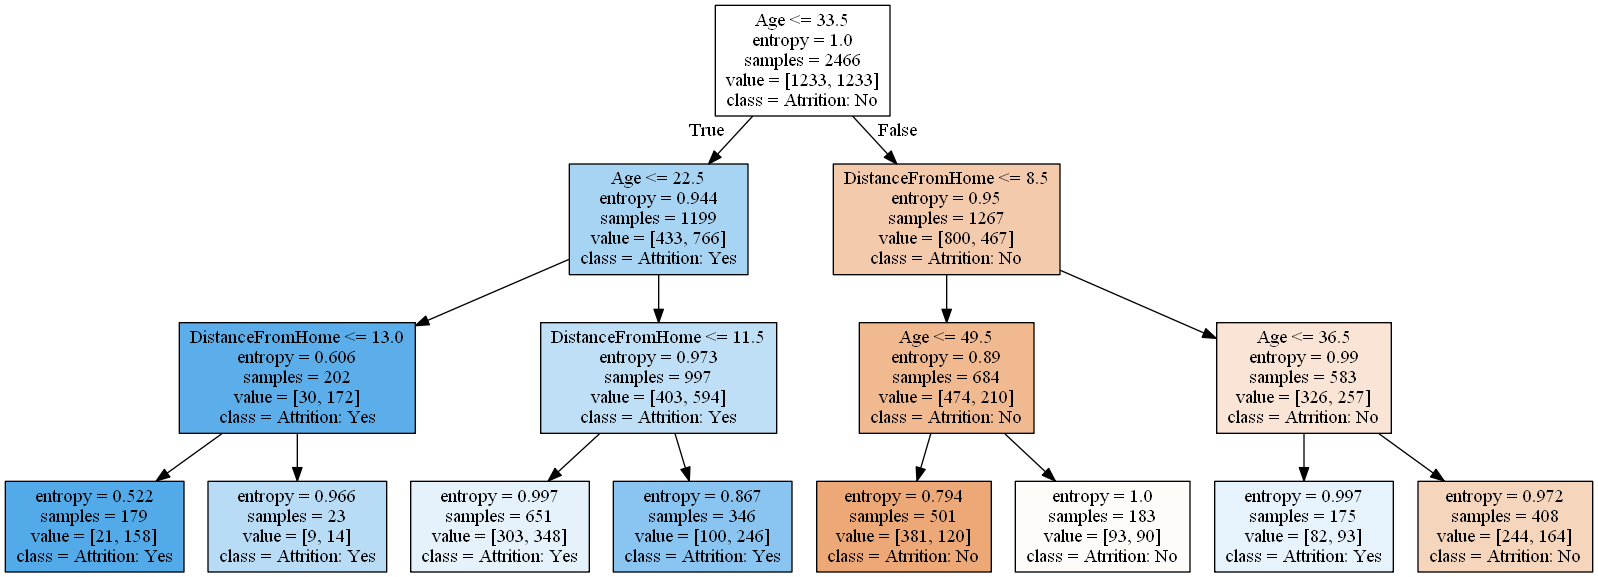

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

#This initiates the DecisionTreeClassifier with the attributes that we want
skb_decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 3, #Use the 3 features in SKB
    max_depth = 3 #Tree goes 3 branches down
)
#Fits the decisiontree onto the data
skb_decision_tree.fit(skb_data,target)

dot_data = tree.export_graphviz(
    skb_decision_tree, out_file=None,
    feature_names=skb_data.columns,
    class_names=['Atrrition: No', 'Attrition: Yes'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [20]:
from sklearn.model_selection import cross_val_score 
cross_val_score(skb_decision_tree, skb_data, target, cv=10)

array([0.65322581, 0.63709677, 0.62903226, 0.61382114, 0.60162602,
       0.60569106, 0.63414634, 0.62195122, 0.64634146, 0.60162602])

In [21]:
from sklearn.model_selection import train_test_split
skb_X_train, skb_X_test, skb_y_train, skb_y_test = train_test_split(skb_data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(skb_decision_tree.fit(skb_X_train, skb_y_train).score(skb_X_test, skb_y_test)))
print('Testing on Sample: ' + str(skb_decision_tree.fit(skb_data, target).score(skb_data, target)))

With 20% Holdout: 0.6234817813765182
Testing on Sample: 0.6394971613949716


In [22]:
skb_y_pred = skb_decision_tree.fit(skb_X_train, skb_y_train).predict(skb_X_test)
from sklearn.metrics import confusion_matrix
skb_cnf_matrix = confusion_matrix(skb_y_test, skb_y_pred)
print(skb_cnf_matrix)

[[161  99]
 [ 87 147]]


In [23]:
from sklearn.metrics import classification_report
print(classification_report(skb_y_test, skb_y_pred))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63       260
           1       0.60      0.63      0.61       234

   micro avg       0.62      0.62      0.62       494
   macro avg       0.62      0.62      0.62       494
weighted avg       0.62      0.62      0.62       494



In [24]:
from sklearn import ensemble
#Create a generic random forest tree
skb_rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 3,
    n_estimators = 50
    )

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3, 4, 5]
}
skb_gscv_rfc = GridSearchCV(skb_rfc, parameters, cv=5)
skb_gscv_rfc.fit(skb_data, target)
print(cross_val_score(skb_rfc, skb_data, target, cv=10))
print(cross_val_score(skb_gscv_rfc.best_estimator_, skb_data, target, cv=10))

[0.65725806 0.64919355 0.60080645 0.62195122 0.59349593 0.64227642
 0.67479675 0.65853659 0.63821138 0.60162602]
[0.71774194 0.69758065 0.60483871 0.63414634 0.65447154 0.66666667
 0.70325203 0.69105691 0.65447154 0.65447154]


In [25]:
#X_train, X_test, y_train, y_test = train_test_split(skb_data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(skb_gscv_rfc.fit(skb_X_train, skb_y_train).score(skb_X_test, skb_y_test)))
print('Testing on Sample: ' + str(skb_gscv_rfc.fit(skb_data, target).score(skb_data, target)))

With 20% Holdout: 0.6619433198380567
Testing on Sample: 0.6889699918896999


In [26]:
skb_y_pred = skb_gscv_rfc.fit(skb_X_train, skb_y_train).predict(skb_X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(skb_y_test, skb_y_pred)
print(cnf_matrix)

[[185  75]
 [ 78 156]]


In [27]:
from sklearn.metrics import classification_report
print(classification_report(skb_y_test, skb_y_pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       260
           1       0.68      0.67      0.67       234

   micro avg       0.69      0.69      0.69       494
   macro avg       0.69      0.69      0.69       494
weighted avg       0.69      0.69      0.69       494



# PCA:

In [28]:
from sklearn.decomposition import PCA
#Here we are setting pca to be fitted with n_components = 2, this is because after the 2 largest variables the amount of variance
#increase is much less significant
pca = PCA(n_components=2)
pca_transformed_data = pca.fit_transform(feature_selected_data) 

print(pca.explained_variance_ratio_) #Shows how much variance the first and second dimensional space has
print(pca.explained_variance_ratio_.cumsum())  #Shows that with n_components=2, I retain .98% of the variance cumaltively

[0.56075657 0.42253679]
[0.56075657 0.98329336]


--- 0.0 seconds ---


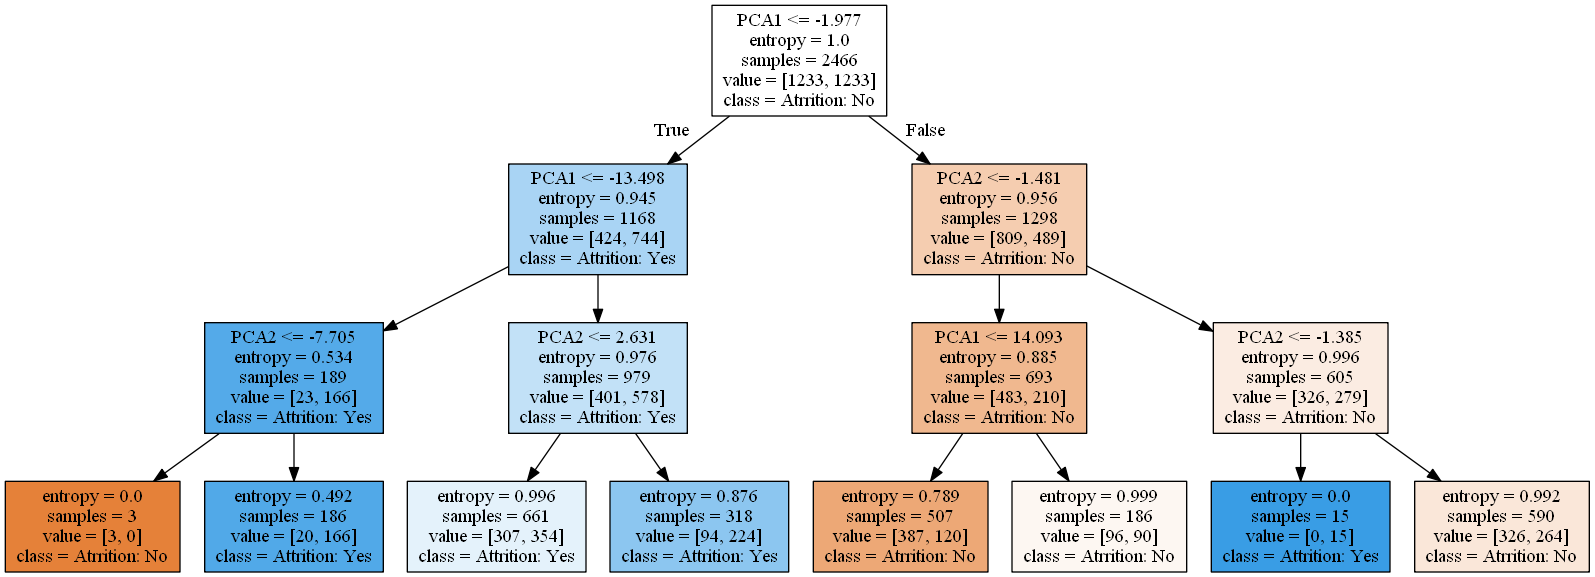

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

#This initiates the DecisionTreeClassifier with the attributes that we want
pca_decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 2, #Use the 2 features in PCA
    max_depth = 3 #Tree goes 3 branches down
)
#Fits the decisiontree onto the data
pca_transformed_data = pca.fit_transform(feature_selected_data)
pca_decision_tree.fit(pca_transformed_data,target)

dot_data = tree.export_graphviz(
    pca_decision_tree, out_file=None,
    feature_names=['PCA1','PCA2'],
    class_names=['Atrrition: No', 'Attrition: Yes'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [30]:
from sklearn.model_selection import cross_val_score 
cross_val_score(pca_decision_tree, pca_transformed_data, target, cv=10)

array([0.64112903, 0.59677419, 0.61693548, 0.60569106, 0.59349593,
       0.6504065 , 0.65447154, 0.64227642, 0.6300813 , 0.61382114])

In [31]:
from sklearn.model_selection import train_test_split
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_transformed_data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(pca_decision_tree.fit(pca_X_train, pca_y_train).score(pca_X_test, pca_y_test)))
print('Testing on Sample: ' + str(pca_decision_tree.fit(pca_transformed_data, target).score(pca_transformed_data, target)))

With 20% Holdout: 0.611336032388664
Testing on Sample: 0.6370640713706407


In [32]:
pca_y_pred = pca_decision_tree.fit(pca_X_train, pca_y_train).predict(pca_X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(pca_y_test, pca_y_pred)
print(cnf_matrix)

[[171  89]
 [103 131]]


In [33]:
from sklearn.metrics import classification_report
print(classification_report(pca_y_test, pca_y_pred))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       260
           1       0.60      0.56      0.58       234

   micro avg       0.61      0.61      0.61       494
   macro avg       0.61      0.61      0.61       494
weighted avg       0.61      0.61      0.61       494



In [34]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.3050706386566162 seconds ---


In [35]:
from sklearn import ensemble
#Create a generic random forest tree
pca_rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 3,
    n_estimators = 50
    )

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3, 4, 5]
}
pca_gscv_rfc = GridSearchCV(pca_rfc, parameters, cv=5)
pca_gscv_rfc.fit(pca_transformed_data, target)
print(cross_val_score(pca_rfc, pca_transformed_data, target, cv=10))
print(cross_val_score(pca_gscv_rfc.best_estimator_, pca_transformed_data, target, cv=10))

[0.66129032 0.64112903 0.625      0.61382114 0.62195122 0.63821138
 0.6504065  0.64634146 0.64227642 0.60569106]
[0.68951613 0.72177419 0.68951613 0.66666667 0.65447154 0.71138211
 0.69512195 0.69105691 0.68292683 0.65853659]


In [36]:
print('With 20% Holdout: ' + str(pca_gscv_rfc.fit(pca_X_train, pca_y_train).score(pca_X_test, pca_y_test)))
print('Testing on Sample: ' + str(pca_gscv_rfc.fit(pca_transformed_data, target).score(pca_transformed_data, target)))

With 20% Holdout: 0.6740890688259109
Testing on Sample: 0.7238442822384428


In [37]:
pca_y_pred = pca_gscv_rfc.fit(pca_X_train, pca_y_train).predict(pca_X_test)
from sklearn.metrics import confusion_matrix
pca_cnf_matrix = confusion_matrix(pca_y_test, pca_y_pred)
print(pca_cnf_matrix)

[[162  98]
 [ 71 163]]


In [38]:
from sklearn.metrics import classification_report
print(classification_report(pca_y_test, pca_y_pred))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66       260
           1       0.62      0.70      0.66       234

   micro avg       0.66      0.66      0.66       494
   macro avg       0.66      0.66      0.66       494
weighted avg       0.66      0.66      0.66       494



In [39]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 111.31475591659546 seconds ---


# Overall Summary:
Random Forest Trees take a variable amount of time depending on how large you make the forest (n_estimator). However they are by far much easier to implement then decision trees as well as much more accurate. Across the 3 different feature selection methods, random forest trees is always much more accurate then the decision tree.

Between all the feature selection models, the method where we use all five of the regular features is most accurate, whereas PCA is the least accurate. This is not surprising as the original feature selection contains the most variables, whereas PCA contained the least. PCA compared to SelectKBest are relatively comparable, and PCA would most likely overthrow SelectKBest if the amount of features it was allowed to retain would be equal to the amount for SelectKBest. (PCA had 2, SKB had 3)

Between the three different feature selection methods, I would say the original feature selection method is the easiest to visualize however would also be the  most inefficient. If the dataset was larger or if there were more features, there would be alot of lost efficiency when computing the accuracy of the model. SelectKBest is also extremely easy to visualize as well as much more efficient then manually selecting features. However it can fall short when trying to explore intricacies of the data as you need to depend on a "scorer" to help you select which features are the most efficient which could result in loss details. PCA is the hardest to visualize but is the most efficient.

# Personal Notes
Things I still don't really understand:
1. So basically PCA and SelectKBest are both feature selectors and are used to best find the features that provide the biggest variance. SelectKBest does this by applying a model (which is is more often or not chi2 based on examples I have seen online, but svc also works **but im not really sure how to use svc (from sklearn.svm import SVC) or if I should use it as it seems to be a very customizable model type and I am not sure what attributes to input into it**). PCA on the other hand takes all the features or data columns you give it, finds the dimensions that provide the greatest amount of variance and returns n_components of them to you. 

So my question is, since they are both basically feature selection types, should I combine using them? And if so what kind of model should I put into SelectKBest (since PCA can return negative integers, I then cannot use the usual chi2 model, which means I have to use svc to which I am not sure what to input as the attributes to svc). 

**Answer: Do not combine them use them seperately depending on the goal

2. Because I used PCA to fit and transform my dataset, do I also need to apply this to my target? Currently one major issue I am getting is that my y_pred values are always full of 0s without a single one, I am assuming this is because my target was also not adjusted along with the data when I applied PCA to it. If so, what should I write to accomplish this? pca_target = pca.fit(target)?

**Answer: This is due to the fact that I did not resample my data, so the data was heavily skewed resulting in a bad y_pred

What I believe to understand so far: **Basically Correct** 
 I now have a better understanding of the flow of how my data should go namely in these 4 steps:
    1. Retrieve the data and explore it, do this by making visual graphs with things like seaborn or matplotlib, to help find corelations between different columns in the data and explain the data to the audience to help them understand data uniqueness and what they should be focusing on. 
    2. Feature Selection: Use PCA, SelectKBest, Recursive Feature Elimination (which we havn't relaly done yet) to help narrow down the features that you decide to use for your model. In this case, I currently enjoy using SelectKBest because its output directly reflects the features you put in, so if you put in 5 columns into SelectKBest, it'll select the 2 or 3 best features that you should keep. Whereas in PCA since it combines multiple features into newer features, its harder to convey which of the original features are most important in fixing whatever the issue/question it is that we are trying to answer with our data analysis. 
    3. Applying Decision Tree/Random Forest Tree model to the features retrieved from #2. Decision Trees being easier to see how our features are being weighted and random forest tree being harder to see how our features are being selected but is more accurate and easier to implement (and supposedly faster but im not getting it faster atm)
    3. Use Hold Outs, Cross Validations, Confusion Matrix, and Classification Reports to analyze how effective said models are. Hold outs are basically the same as Cross Validations except that Cross Validations must split the data into equal pieces, while in hold outs you can split it however you want. Confusion Matrix vs Classification Report, is that Classification Report gives you alot more detail in regards to how well your data does in comparison to what the "true" values are, and Confusion Matrix simply displays out of what number instances in which your model predicted each feature to be correct or incorrect. 